63f78014766fd30436c18a79_Hyperspace - navbar logo.png

# Movie Recommender Using Hyperspace

In This walkthrough we will explore the use of Hyperspace hybrid search to create a movie recommendation system. The hybrid search combines lexical (classic) and vector search.

In addition, we use aggregations to gain insights on the recommended movies.

The dataset metadata can be downloaded from [AWS](https://hyperspace-datasets.s3.eu-central-1.amazonaws.com/MoviesEmbedding.csv).
The relevent score functions can be downloaded from the following links: [score function 1](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/MovieRecommendation/movie_aggregation_function.py), [score function 2](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/MovieRecommendation/movies_score_function.py).


For more info, see the [Hyperspace documentation](https://docs.hyper-space.io/hyperspace-docs/getting-started/overview).


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/MovieRecommendation/MoviesRecommendationHybridSearch.ipynb)

# Hyperspace Hybrid search
The hybrid search in this notebook combines metadata filtering and brute force(accurate) KNN. In this scenario, Hyperspace uses the pre-filtering approach, by which the metadata is first filtered and the KNN is applied only on vectors that pass the inital filtering. For KNN, this approach optimizaes the query latency, without reducing its recall. This approach also ensures each users will only be exposed to part of the database.

The score of the multi vector search is combined using weights.
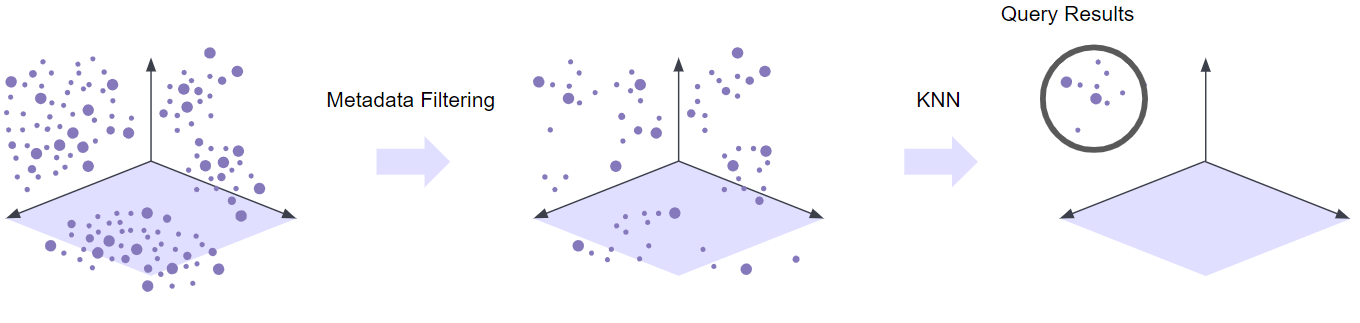


## Limiations of Post Filtering and Top K Candidtaes
A significant drawback of the post-filtering approach is its inability to precisely determine the top K candidates. As filtering occurs after the ANN phase, it's challenging to preemptively define the exact number of desired results. One potential solution is to employ a substantially larger value for K in the KNN, with the expectation that at least K documents will endure the filtering process.


# The Dataset
The data is taken from [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/). The data includes 40951 valid movies.

## The Dataset Fields
The processed [metadata](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/MovieRecommendation/Movie_Recommendation_Processed.csv) includes the following fields:

1.   **adult** [boolean] - states if the movie is rated 18+
2.   **belongs_to_collection** [Keyword] - name of the collection that includes the movie. If the movie is not a part of a collection, value will be "None"
3. **budget** [integer] - The budget of the movie in USD
4. **genres** [list[Keyword]] - list of movie genres (i.e drama)
5. **id** [integer]] - unique id per movie
6. **original_language** [Keyword] - the original language in which the movie was produced
7. **popularity** [float] - the popularity of the movie, formulated as an unbounded score
8. **production_companies** [list[Keyword]] - list of production companies involved in the movie
9. **production_countries** [list[Keyword]] - list of all countries in which the movie was filmed
10. **rating** [float] - the movie IMDB weighted average rating  score
11. **release_date_unix_time** [int] - the movie release date in unix time
12. **revenue** [float] - the movie rvenue in [USD]
13. **runtime_days** [int] - the number cinema run time days
14. **spoken_languages** [list[Keyword]] - list of all languages spoken in the movie
15. **title** [Keyword] - the movie title

In addition, this dataset include two embedded text vectors:

16. **overview embedding** [list[float]] - embedding of the movie description text
17. **tagline embedding** [list[float]] - embedding of the movie tagline text

The text embedding was performed using the **all-MiniLM-L6-v2** model by [Huggingface](https://huggingface.co/models), where each embedded vector is of dimension 384.

# Loading the Data
The first step it load the movie metadata in an SQL from, using pandas.


In [1]:
import pandas as pd
import warnings
import numpy as np

data_path = 'MoviesEmbedding.csv'
df = pd.read_csv(data_path)

def to_vec(x):
  vec = x[1:-1].replace("   "," ").replace("  "," ").replace(",","").split(" ")
  return [float(xx) for xx in vec if xx != ""]

warnings.filterwarnings('ignore')

df["runtime_days"] = df["runtime_days"].astype(int)
df['embedded_overview'] = df['embedded_overview'].apply(lambda x : to_vec(x))
df['embedded_tagline'] = df['embedded_tagline'].apply(lambda x : to_vec(x))
df['id'] = range(0, df.shape[0])
df["id"] = df["id"].apply(lambda x: str(x))
df['belongs_to_collection'] = df['belongs_to_collection'].fillna(np.nan).replace([np.nan], [None])

del(df["Unnamed: 0"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40951 entries, 0 to 40950
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  40951 non-null  bool   
 1   belongs_to_collection  4196 non-null   object 
 2   budget                 40951 non-null  int64  
 3   genres                 40951 non-null  object 
 4   id                     40951 non-null  object 
 5   popularity             40951 non-null  float64
 6   production_companies   40951 non-null  object 
 7   production_countries   40951 non-null  object 
 8   revenue                40951 non-null  float64
 9   runtime_days           40951 non-null  int32  
 10  spoken_languages       40951 non-null  object 
 11  title                  40951 non-null  object 
 12  year                   40951 non-null  int64  
 13  rating                 40951 non-null  float64
 14  unix_time              40951 non-null  int64  
 15  em

Let us briefly examine some of the data columns

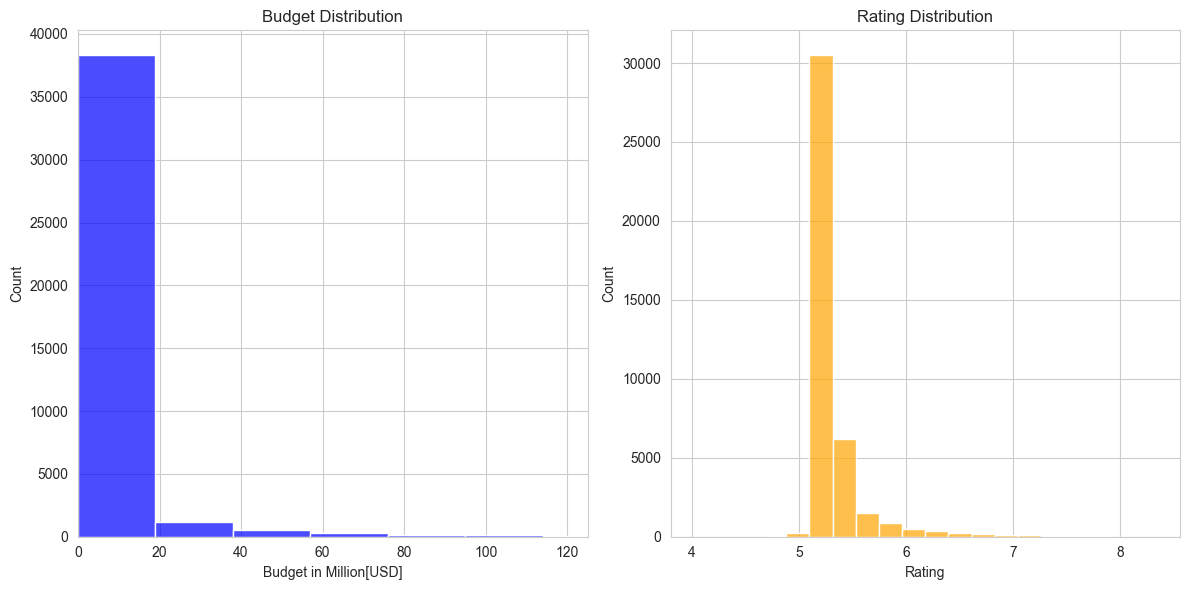

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

df["budget_for_draw"] = df["budget"] /1000000
plt.subplot(1, 2, 1)
sns.histplot(data=df, x="budget_for_draw", bins=20, color='blue', alpha=0.7)
plt.title("Budget Distribution")
plt.xlim(0.0, 125)
plt.xlabel("Budget in Million[USD]")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="rating", bins=20, color='orange', alpha=0.7)
plt.title("Rating Distribution")
plt.xlabel("Rating")
del(df["budget_for_draw"])
plt.tight_layout()
plt.show()


It can be seen that the vast majority of movies have a budget lower than 20 million USD. The rating distribution is non-symmetric, with a maximum rating slightly above 5. We will incorporate these insights into the score function that we will soon build, providing positive and negative score boosts based on these statistics.

# Using the Hyperspace Engine
In the next step will Setting the environment requires the following steps


1. Install the client API
2. Connect to a server
3. Create data schema file
4. Create collection
5. Ingest data
6. Run query

## 1. Install the client API
Hyperspace API can be installed directly from Hyperspace git, using the following command:

In [3]:
pip install git+https://github.com/hyper-space-io/hyperspace-py


  Cloning https://github.com/hyper-space-io/hyperspace-py to c:\users\tamirbracha\appdata\local\temp\pip-req-build-_l97_2rr
  Resolved https://github.com/hyper-space-io/hyperspace-py to commit c49c83710c5b466a4bb299f7ad70f618d3a6df94
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/hyper-space-io/hyperspace-py 'C:\Users\TamirBracha\AppData\Local\Temp\pip-req-build-_l97_2rr'
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Download dataset

In [4]:
from urllib.request import urlretrieve
import os

def download_data(url, file_name):
    """
    url (str): URL of the file to download.
    file_name (str): Local path where the file will be saved.
    """
    # Check if the file already exists and is not empty
    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
        print(f"The file {file_name} already exists and is not empty.")
    else:
        try:
            # Attempt to download the file from `url` and save it locally under `file_name`
            urlretrieve(url, file_name)
            # Check if the file was downloaded and is not empty
            if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                print(f"Successfully downloaded {file_name}")
            else:
                print("Download failed or file is empty.")
                
        except Exception as e:
            print(f"An error occurred: {e}")

In [6]:
data_url = "https://hyperspace-datasets.s3.eu-central-1.amazonaws.com/MoviesEmbedding.csv"
download_data(data_url, "./MoviesEmbedding.csv")

Successfully downloaded ./MoviesEmbedding.csv


## 2. Connect to a server

Once the Hyperspace API is installed, the database can be accessed by creating a local instance of the Hyperspace client. This step requires host address, username and password.

In [ ]:
import hyperspace
from getpass import getpass

username = "USERNAME"
host = "HOST_URL"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=getpass())


Before continuing, let us check that the cluster is live using the  "**collections_info()**" command

In [ ]:
status = hyperspace_client.collections_info()
display(status)

## 3.   Create a Data Schema File (Index Mapping)

Similarly to other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Here, we create a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" (inner product) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.

Here, we use standrad inner product (metric = IP) with exact KNN (index = brute_force).

In [ ]:
import json

config = {
  "configuration": {
    "adult": {
      "type": "boolean"
    },
    "belongs_to_collection": {
      "type": "keyword"
    },
    "budget": {
      "type": "integer"
    },
    "genres": {
      "struct_type": "list",
      "type": "keyword"
    },
    "id": {
      "type": "keyword",
      "id": True
    },
    "original_language": {
      "type": "keyword"
    },
    "popularity": {
      "type": "float"
    },
    "production_companies": {
      "struct_type": "list",
      "type": "keyword"
    },
    "production_countries": {
      "struct_type": "list",
      "type": "keyword"
    },
    "rating": {
      "type": "float"
    },
    "release_date_unix_time": {
      "type": "date"
    },
    "revenue": {
      "type": "float"
    },
    "runtime_days": {
      "type": "integer"
    },
    "spoken_languages": {
      "struct_type": "list",
      "type": "keyword"
    },
    "title": {
      "type": "keyword"
    },
     "embedded_overview": {
            "type": "dense_vector",
            "dim": 384,
            "index_type": "brute_force",
            "metric": "IP"
      },
    "embedded_tagline": {
      "type": "dense_vector",
      "dim": 384,
      "index_type": "brute_force",
      "metric": "IP"
      }

  }
}

with open('MovieRecommendation_config.json', 'w') as f:
    f.write(json.dumps(config, indent=2))

collection_name = 'Movies'


## 4. Create Collection
The Hyerspace engine stroes data in Collections, where each collecction commonly hosts data of similar context, etc. Each search is then perfomed within a collection. We create a collection using the command "**create_collection**(schema_filename, collection_name)".

In [ ]:
collections_info = hyperspace_client.collections_info()

In [ ]:
collection_name = 'Movies'
if collection_name not in hyperspace_client.collections_info()["collections"]:
  hyperspace_client.create_collection('MovieRecommendation_config.json', collection_name)
hyperspace_client.collections_info()


## 5. Ingest data

In the next step we ingest the dataset in batches of 500 documents to the Hyperspace database. This number can be controlled by user, and in particular, can be increased in order improve ingestion time. We add batches of data using the command **add_batch**(batch, collection_name).

In [ ]:
import time
BATCH_SIZE = 100

def chunker(df, size):
    return (df.iloc[pos:pos + size] for pos in range(0, len(df), size))

start = time.time()

i = 0

for chunk in chunker(df.iloc[i:], BATCH_SIZE):
    batch = [dict(row) for j, row in enumerate(chunk.to_dict('records'))]

    i += BATCH_SIZE

    if i % BATCH_SIZE == 0:
        response = hyperspace_client.add_batch(batch, collection_name)
        print(i, response)
        batch.clear()


hyperspace_client.commit('Movies')
time = (time.time() - start)
print(f"ingestion took: {time} sec")

## 6. Running The Query

### Creating The Query
We will first run a vector search, followed by a hybrid search which includes analytic logic - boost based on rating, genres, etc. Let's start with vector search.


As an input vector, we choose '*Star Wars*', a Sci-Fi action movie
The overview text:
**"Princess Leia is captured and held hostage by the evil Imperial forces in their effort to take over the galactic Empire. Venturesome Luke Skywalker and dashing captain Han Solo team together with the loveable robot duo R2-D2 and C-3PO to rescue the beautiful princess and restore peace and justice in the Empire."**

In [ ]:
collection_name = 'Movies'

input_vector = hyperspace_client.get_document(document_id='215', collection_name=collection_name)
{field: input_vector[field] for field in input_vector.keys() if "embed" not in field}

### Classic Search
Let us use the score function, and run classic search (keyword matching). We require that the search will nor return the input movie in the score function.

Hyperspace queries are created in python format and saved as strings. Classic search requires a pre-created score function.

The next step is use the query logic and apply the query.

### Loading the score function
The score function encorporates logic based on movied budget and rating, and gives bonus to movies of similar production_companies. Only movies of the same genre are returned. We will use two score functions. The first is used only for matching similar movies, while the other will perform agrregrations on the returned data.

In [ ]:
import inspect

def set_score_function(func, collection_name, score_function_name='func'):
    source = inspect.getsource(func)
    with open('sf.py', 'w') as f:
        f.write(source)
    hyperspace_client.set_function('sf.py', collection_name, score_function_name)

In [ ]:
hyperspace_client.get_schema(collection_name)

In [ ]:
def popular_movies_recommendation(params, doc):
  score0 = 0.0
  score1 = 0.0
  sum_score = 0.0
  boost = 1.0
  if match('genres') and not match('title'):
    score1 = rarity_sum('genres')
    score1 += 20.0

    if match('production_companies'):
      score1 += rarity_sum('production_companies')

    if doc["rating"] >= 7.0:
        score0 += 10.0
    elif doc["rating"] >= 6.5:
        score0 += 6.0
    elif doc["rating"] < 5.2:
        score0 -= 2.0
    score1 = max(score0, score1)

    boost = 1.0
    if match('belongs_to_collection'):
        boost = 2.0

    if doc["budget"] >= 20000000:
        score0 += 5.0

    sum_score = boost * (score0 + score1)

    if doc["runtime_days"] > 200:
      sum_score = sum_score + 8

    return boost * sum_score

  return 0.0


set_score_function(popular_movies_recommendation, collection_name, score_function_name='popular_movies_recommendation')

In the next step, we run the search

In [ ]:
print("searching for matches for '",input_vector["title"],"'")
print("-"*180)

query = {
    'params': input_vector
}
results = hyperspace_client.search(query,
                                        size=20,
                                        function_name='popular_movies_recommendation',
                                        collection_name=collection_name,
                                        fields = ["title","production_companies"])

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("-"*180)


print("{:<5} {:<10} {:<40}  {:<100} {:<10}".format("Rank", "ID", "title","production_companies", "Score"))
print("="*180)

for i, result in enumerate(results['similarity']):
    print("{:<5} {:<10} {:<40}  {:<100}  {:<10}".format(i + 1, result['document_id'], result['fields']['title'][:40],result['fields']["production_companies"], round(result['score'], 2)))


### Vector Search
We start with a simple search function, based on matching of embedded vectors using inner product and accurate KNN. We will use the fact that Hyperspace allows multi vector KNN ,and use both embedded_overview and embedded_tagline fields.

In [ ]:
query = {
    'params': input_vector,
    "knn": [{'field': "embedded_overview", 'boost': 0.0},
            {'field': "embedded_tagline", 'boost': 1.0}]
}
results = hyperspace_client.search(query,
                                        size=20,
                                        collection_name=collection_name)
candidates = results['candidates']



print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")
print(f"Query run time = {results['took_ms']}ms")
print("-------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))


Many of these movies are not exactly children's movies and the list appears less relevant than the classic search result

### Hybrid Search
In the next step we apply Hybrid search, which combines classic and vector search. The query will continue to use both embedded vector fields.

In [ ]:
print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")

query_with_knn = {
    'params': input_vector,
    'knn': [{'field':'query','boost': 0.005},
            {'field':'embedded_overview','boost': 0.5},
            {'field':'embedded_tagline','boost': 0.5}]
}

results = hyperspace_client.search(query_with_knn,
                                        size=20,
                                        function_name='popular_movies_recommendation',
                                        collection_name=collection_name)

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("------------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))

In the case of vector-based search, the recommended movies were not always be relevant. While the original movie was intended for children, the retrieved movies were not consistently within the same category. The results from the traditional search appeared more suitable, yet some of them were also less similar to the imput movier.

The hybrid search results appear to be better suited than those from the vector and classic searches conducted separately.

### Vector Distance in Score Function
As a second example of Hybrid search, we encorporate the vector search in the score function


In [ ]:
def distance_score_function(Q, V):
  score0 = 0.0
  score1 = 0.0
  sum_score = 0.0
  boost = 1.0
  score = 0.0
  if match('genres') and not match('title'):
    score1 = rarity_sum('genres')
    score1 += 20.0


    if match('production_companies'):
      score1 += rarity_max('production_companies')

    if V["rating"] >= 7.0:
      score0 += 10.0
    elif V["rating"] >= 6.5:
      score0 += 6.0
    elif V["rating"] < 4.5:
      score0 -= 2.0
    score1 = max(score0, score1)

    boost = 1.0
    if match('belongs_to_collection'):
      boost = 2.0

    if V["budget"] >= 1000000:
      score0 += 5.0

    sum_score = boost * (score0 + score1)

    if V["runtime_days"] > 200:
      sum_score = sum_score + 8

    score = boost * sum_score
  else:
    return 0

  return distance("embedded_overview", min_score = 1.0) + 0.01 * score

set_score_function(distance_score_function, collection_name, score_function_name='distance_score_function')

In [ ]:
print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")
# input_vector["min_score"] = 1.1

results = hyperspace_client.search(input_vector,
                                   size=20,
                                   function_name='distance_score_function',
                                   collection_name=collection_name,
                                   fields = ["title", "production_companies"])

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("-"*180)


print("{:<5} {:<10} {:<40}  {:<100} {:<10}".format("Rank", "ID", "title","production_companies", "Score"))
print("="*180)

for i, result in enumerate(results['similarity']):
    print("{:<5} {:<10} {:<40}  {:<100}  {:<10}".format(i + 1, result['document_id'], result['fields']['title'][:40],result['fields']["production_companies"], round(result['score'], 2)))


# Hybrid Search and Agggregations
In the final part, we will use a different score function to aggregatre various fields of the data. The aggregation is perfomed in the score function, where each aggregation is perfomed over all candidates that passed the filtering up to the step that hosts it.

We perform the following aggregations:

**For all matching movies**
*   Max Rating
*   Min Rating
*   Average Rating
*   Max popularity
*   Min popularity

**For subsets**
*   Count of movies with rating >= 7
*   Average revenue movies with rating >= 7
*   Average revenue movies with runtime >= 200 days

The aggregations are defined in the score function, and are returned under  designated keys in the result dictionary

In [ ]:
def movies_aggregation(Q, V):
  score0 = 0.0
  score1 = 0.0
  sum_score = 0.0
  boost = 1.0
  if match('genres') and match("adult") and not match('title'):
    aggregate_max("total max_rating", "rating")
    aggregate_avg("total avg_rating", "rating")
    aggregate_min("total min_rating", "rating")
    aggregate_max("total max_popularity", "popularity")
    aggregate_avg("total avg_popularity", "popularity")

    score1 = rarity_sum('genres')
    score1 += 20.0

    if match('belongs_to_collection'):
      boost = 2.0

    if match('production_companies'):
      score1 += rarity_sum('production_companies')

    if V["rating"] >= 7.0:
        aggregate_count("count movies with rating >= 7.0")
        aggregate_avg("avg revenue for rating >= 7.0", "revenue")
        score0 += 10.0
    elif V["rating"] >= 6.5:
        score0 += 6.0
    elif V["rating"] < 4.5:
        score0 -= 2.0
    score1 = max(score0, score1)

    boost = 1.0
    if match('belongs_to_collection'):
        boost = 2.0

    if V["budget"] >= 1000000:
        aggregate_avg("avg revenue for movies with budget >= 1m", "revenue")
        score0 += 5.0

    sum_score = boost * (score0 + score1)

    if V["runtime_days"] > 200:
      aggregate_avg("avg revenue for movies with runtime_days > 200d", "revenue")
      sum_score = sum_score + 8

    return boost * sum_score


set_score_function(movies_aggregation, collection_name, score_function_name='movies_aggregation')

In [ ]:
print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")

results = hyperspace_client.search(query_with_knn,
                                        size=10,
                                        function_name='movies_aggregation',
                                        collection_name=collection_name)

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("------------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))


print("\n----------------- Aggregations --------------------")
print("{:<50} {:<15}".format("Aggregation", "Value"))
print("="*55)

for i, agg in enumerate(results['aggregations']):
    if results['aggregations'][agg]['agg_type'] == "count":
        print("{:<50} {:<15}".format(agg, results['aggregations'][agg]["count"]))
    else:
        print("{:<50} {:<15}".format(agg, round(results['aggregations'][agg]["value"],2)))

This notebook gave a simple example of the use of the Hyperspace engine for hybrid search. Hyperspace can support signficantly more complicated use cases with large databases, in extremley low latency.
For more information, visit us at [Hyperspace](https://www.hyper-space.io/)